In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_decision_forests as tfdf
from IPython.display import Markdown as md, display
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
import copy
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'tensorflow_decision_forests'

# Helper

In [ ]:
def display_full(x: pd.DataFrame, n_digits: int = 2):
    pd.set_option("display.max_rows", len(x))
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 2000)
    pd.set_option("display.float_format", ("{:20,." + str(n_digits) + "f}").format)
    pd.set_option("display.max_colwidth", None)
    pd.set_option("display.max_seq_item", None)
    display(x)
    pd.reset_option("display.max_rows")
    pd.reset_option("display.max_columns")
    pd.reset_option("display.width")
    pd.reset_option("display.float_format")
    pd.reset_option("display.max_colwidth")
    pd.reset_option("display.max_seq_item")

# Dataset

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
#ubmission_df = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Data description:

1. Survival - Survival (0 = No; 1 = Yes). Not included in test.csv file.
2. Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
3. Name - Name
4. Sex - Sex
5. Age - Age
6. Sibsp - Number of Siblings/Spouses Aboard
7. Parch - Number of Parents/Children Aboard
8. Ticket - Ticket Number
9. Fare - Passenger Fare
10. Cabin - Cabin
11. Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

# Data Visualization Methods

In [ ]:
target_column = 'Survived'

def create_submission_file(passenger_id_to_prediction_map: dict[int, int]):
    output = pd.DataFrame({'PassengerId': list(passenger_id_to_prediction_map.keys()), 
                           target_column: passenger_id_to_prediction_map.values()})
    output.to_csv('submission.csv', index=False)
    
def show_kde(feature_names):
    df = train_df[feature_names]
    fig, axs = plt.subplots(1,len(feature_names))
    
    for feature, ax in zip(feature_names, axs):
        df[feature].plot(kind='density', ax=ax)
        
    fig.show()
    
def show_corr_between_continues_features_and_target(feature_names):
    df = train_df[feature_names + [target_column]]
    corr_matrix = df.corr()[target_column]
    display(corr_matrix)
    
def show_corr_between_discrete_features_and_target(feature_names):
    targets = train_df[target_column]
    feature_to_corr = {}
    
    for feature in feature_names:
        feature_values = train_df[feature].to_list()

            
        # Cramér's V
        confusion_matrix = pd.crosstab(feature_values, targets)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2/n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        corr = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
        
        feature_to_corr[feature] = corr
    return feature_to_corr
    
def show_columns_with_nan_values(df):
    columns_with_nan_values = df.columns[df.isna().any()].tolist()
    column_to_amount_of_values = {
      column: np.sum(df[column].isna()) for column in columns_with_nan_values
    }
    total_length = len(df)
    
    df = {
        "column": list(column_to_amount_of_values.keys()),
        "#_without_value": list(column_to_amount_of_values.values()),
        "%_without_value": [value / total_length for value in column_to_amount_of_values.values()]
    }
    display(pd.DataFrame(df))

In [ ]:
display(md('### train_df'))
show_columns_with_nan_values(train_df)

### train_df

,column,#_without_value,%_without_value
0,Age,177,0.198653
1,Cabin,687,0.771044
2,Embarked,2,0.002245


In [ ]:
display(md('### test_df'))
show_columns_with_nan_values(test_df)

### test_df

,column,#_without_value,%_without_value
0,Age,86,0.205742
1,Fare,1,0.002392
2,Cabin,327,0.782297


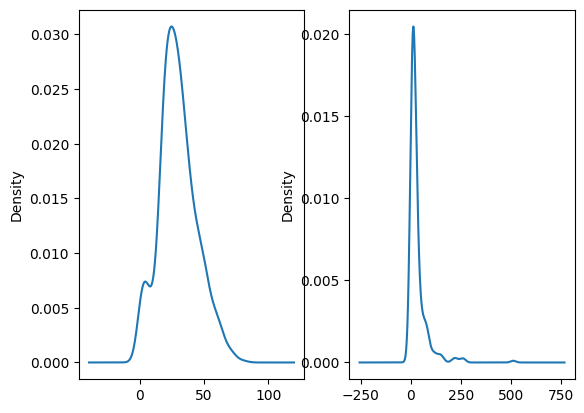

In [ ]:
show_kde(['Age', 'Fare'])

In [ ]:
show_corr_between_continues_features_and_target(['Age', 'Fare'])

Age        -0.077221
Fare        0.257307
Survived    1.000000
Name: Survived, dtype: float64

In [ ]:
show_corr_between_discrete_features_and_target(['Embarked', 'Pclass', 'Sex', 'SibSp', 'Parch'])

{'Embarked': 0.16605833339661635,
 'Pclass': 0.33668387622245516,
 'Sex': 0.5401999468101071,
 'SibSp': 0.18742816095927223,
 'Parch': 0.15693364431605167}

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### What about tickets and Cabin?
* it can be possible that passengers with the same ticket shared a cabin or that they died together

In [ ]:
print("Ticket intersection between test and train: ", len(set(train_df['Ticket'].to_list()).intersection(test_df['Ticket'].to_list())))

Ticket intersection between test and train:  115


In [ ]:
print("Cabin intersection between test and train: ", len(set(train_df['Cabin'].to_list()).intersection(test_df['Cabin'].to_list())))

Cabin intersection between test and train:  38


# Feature Engineering 

In [ ]:
UNKNOWN_DECK = 'U'
UNINTERESTING_TICKET = '69'
    
def add_last_name_column(df: pd.DataFrame):
    df = df.copy()
    df['last_name'] = df['Name'].str.split(pat=',').apply(lambda splitted_name: splitted_name[0])
    return df


def add_family_size(df: pd.DataFrame):
    df = df.copy()
    df['family_size'] = df['SibSp'] + df['Parch']
    return df

def add_deck(df: pd.DataFrame):
    df = df.copy()
    # replace Nones by UNKNOWN_DECK and get rid of double cabins 
    df['deck'] = df['Cabin'].fillna(UNKNOWN_DECK).str.split(pat=' ').apply(lambda splitted: splitted[-1])
    # get first letter only
    df['deck'] = df['deck'].str[0]
    return df


def try_to_fill_missing_deck_values(train_df: pd.DataFrame, test_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    assert 'last_name' in train_df.columns and 'last_name' in test_df.columns
    
    full_df = pd.concat([train_df, test_df]).reset_index(drop=True)
    
    last_name_to_deck_map = dict(zip(full_df['last_name'], full_df['deck']))
    full_df['deck'] = full_df[['deck','last_name']].apply(lambda row: last_name_to_deck_map.get(row['last_name'], UNKNOWN_DECK) 
                                                          if row['deck'] == UNKNOWN_DECK else row['deck'], axis=1)
    
    
    ticket_to_deck_map = dict(zip(full_df['Ticket'], full_df['deck']))
    full_df['deck'] = full_df[['deck','Ticket']].apply(lambda row: ticket_to_deck_map.get(row['Ticket'], UNKNOWN_DECK) 
                                                      if row['deck'] == UNKNOWN_DECK else row['deck'], axis=1)
    
    
    
    full_df['deck'] = predict_deck_value_using_model(full_df)
    
    train_df = full_df[full_df['PassengerId'].isin(train_df['PassengerId'].to_list())].copy()
    test_df = full_df[full_df['PassengerId'].isin(test_df['PassengerId'].to_list())].copy()
    
    return train_df, test_df

def predict_deck_value_using_model(df: pd.DataFrame):
    feature_to_use = ['complete_title', 'Fare', 'SibSp', 'Parch','Embarked']

    input_features = pd.DataFrame(columns=feature_to_use)
    
    input_features['Fare'] = fill_nans_with_mean(df, ['Fare'])['Fare']
    
    features_to_encode = [feature for feature in feature_to_use if feature != 'Fare']
    for feature in features_to_encode:
        input_features[feature] = LabelEncoder().fit_transform(df[feature])
        
    
    gboost = GradientBoostingClassifier()
    gboost_params = {
        'n_estimators': [5, 10, 20, 50],
        #'learning_rate': [0.001, 0.01, 0.1, 0.5],
        'max_depth': [2, 3, 4, 5],
        #'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2, 4],
        #'subsample': [0.8, 0.9, 1.0]
    }
    gboost = GridSearchCV(gboost, param_grid=gboost_params, scoring='accuracy', cv=3, n_jobs=4)
    
    
    samples_to_use = df[df['deck'] != UNKNOWN_DECK].index
    
    training_input = input_features.iloc[samples_to_use]
    y = df.iloc[samples_to_use]['deck'].to_list()
    
    gboost = gboost.fit(training_input, y).best_estimator_
    
    predictions = gboost.predict(input_features)
    
    corrected_predictions = []
    for pred, target_or_unknown in zip(predictions, df['deck'].to_list()):
        if target_or_unknown == UNKNOWN_DECK:
            corrected_predictions.append(pred)
        else:
            corrected_predictions.append(target_or_unknown)
    
    return corrected_predictions

def add_ticket_group_size(train_df: pd.DataFrame, test_df: pd.DataFrame):
    full_data = pd.concat([train_df, test_df], ignore_index=True)
    
    grouped_by_ticket = full_data[['Ticket', 'Survived']].groupby('Ticket').agg(list)
    ticket_to_survived = dict(zip(grouped_by_ticket.index, grouped_by_ticket['Survived']))
    full_data['ticket_group_size'] = full_data['Ticket'].apply(lambda ticket: len(ticket_to_survived[ticket]))
    
    
    ticket_group_to_rel_amount_survived = {}
    for ticket_group, survived in ticket_to_survived.items():
        amount_survived = sum([s for s in survived if not np.isnan(s)])
        if len(survived) < 3:
            ticket_group_to_rel_amount_survived[ticket_group] = -1
        else:
            ticket_group_to_rel_amount_survived[ticket_group] = amount_survived / len(survived)
    
    full_data['ticket_group_survived'] = full_data['Ticket'].apply(
        lambda ticket: ticket_group_to_rel_amount_survived[ticket])
    
    return ( full_data[full_data['PassengerId'].isin(train_df['PassengerId'])].copy(), 
            full_data[full_data['PassengerId'].isin(test_df['PassengerId'])].reset_index(drop=True))


def add_title(df: pd.DataFrame):
    df = df.copy()
    df['complete_title'] = df['Name'].str.extract('(\w+\.)')
    df['title'] = df['Name'].str.extract('(\w+\.)')

    titles_to_merge = {
        "Mr.": ["Capt.", "Col.", "Don.", "Jonkheer.", "Major.", "Sir.", "Master."],
        "Mrs.": ["Lady.", "Ms.", "Countess.", "Dona."],
        "Miss.": ["Mme.", "Mlle."]
    }
    
    merged_titles = {}
    for key, values in titles_to_merge.items():
        for value in values:
            merged_titles[value] = key
            
    df['title'] = df['title'].apply(lambda current_title: merged_titles[current_title] 
                                    if current_title in merged_titles else current_title)
    
    # also map Dr.
    df['title'] = df[['title', 'Sex']].apply(lambda row: "Mr." if row['Sex'] == "male" and row['title'] == 'Dr.'
                                             else row['title'], axis=1)
    df['title'] = df[['title', 'Sex']].apply(lambda row: "Mrs." if row['Sex'] == "female" and row['title'] == 'Dr.'
                                         else row['title'], axis=1)
    return df

            
def fill_nans_with_mean_and_standardize(df: pd.DataFrame, feature_names: list[str]):    
    df_copy = df.copy()
    for feature in feature_names:
        mean = df_copy[feature].mean()
        df_copy[feature] = df_copy[feature].fillna(value=mean)
        df_copy[feature] = (df_copy[feature] - df_copy[feature].mean()) / (df_copy[feature].std() + 1e-5)
        
    return df_copy


def fill_nans_with_mean(df: pd.DataFrame, feature_names: list[str]):    
    df_copy = df.copy()
    for feature in feature_names:
        mean = df_copy[feature].mean()
        df_copy[feature] = df_copy[feature].fillna(value=mean)
        
    return df_copy

def show_title_distribution_to_survived(df: pd.DataFrame, column='title'):
    assert column in df.columns
    display(df[[column, 'Survived', 'PassengerId']].groupby([column, 'Survived']).count())
    

In [ ]:
train_df_augmented = train_df
test_df_augmented = test_df

In [ ]:
train_df_augmented = add_last_name_column(train_df_augmented)
test_df_augmented = add_last_name_column(test_df_augmented)

train_df_augmented = add_family_size(train_df_augmented)
test_df_augmented = add_family_size(test_df_augmented)

train_df_augmented = add_deck(train_df_augmented)
test_df_augmented = add_deck(test_df_augmented)

train_df_augmented = add_title(train_df_augmented)
test_df_augmented = add_title(test_df_augmented)

train_df_augmented, test_df_augmented = add_ticket_group_size(train_df_augmented, test_df_augmented)

# Model Code

In [ ]:
COLUMNS_WITH_DISCRETE = ['Pclass', 'Sex', 'deck', 'Embarked', 'title', 'Ticket', 'Cabin', "ticket_group_size"]
COLUMNS_WITH_CONTINUES = ['Age', 'Fare', 'Parch', 'SibSp', "ticket_group_survived", "family_size"]

def get_cross_validation_results(model, X, y):
    cv_results = cross_validate(model, X, y, cv=4, scoring=['accuracy'], return_estimator=True)
    mean_acc = np.mean(cv_results['test_accuracy'])
    
    for estimator in cv_results["estimator"]:
        print(estimator.best_params_)
    
    print(f"Accuracy: {mean_acc}")
    return 
    
    
def get_ensemble_classifier():
    svm = SVC(probability=True)
    gboost = GradientBoostingClassifier()
    
    svm_params = {'C': [0.01, 0.1, 1, 10, 100]}
    gboost_params = {
        'n_estimators': np.arange(5,35, 5),
        'max_depth': [2, 3, 4],
        'learning_rate': [0.01, 0.1],
    }

    svm = GridSearchCV(svm, param_grid=svm_params, scoring='accuracy', cv=5, n_jobs=4)
    gboost = GridSearchCV(gboost, param_grid=gboost_params, scoring='accuracy', cv=5, n_jobs=4)
    
    ensemble = VotingClassifier(estimators=[
        ('gboost', gboost),
        ('svm', svm)
    ], voting='soft')
    return ensemble


def get_xgb_boost_classifier():
    model = XGBClassifier(objective='binary:logistic')
    param_grid = {
        'n_estimators': np.arange(5,50, 5),
        'learning_rate': [0.01, 0.1],
        'max_depth': [2, 3],
        'alpha': [1, 10, 100],
        'lambda': [1, 10, 100],
    }
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0, refit=True)

    return grid_search

def preprocess_df_ordinal_encoded(df: pd.DataFrame, features: list[str]):    
    feature_df = df.copy()[features  + ['PassengerId']]
    
    for feature in COLUMNS_WITH_CONTINUES:
        if feature in features:
            feature_df = fill_nans_with_mean(feature_df, [feature])
           
    for feature in COLUMNS_WITH_DISCRETE:
        if feature in features:
            encoder = LabelEncoder().fit(feature_df[feature])
            feature_df[feature] = encoder.transform(feature_df[feature])

        
    feature_df = feature_df.drop(columns=['PassengerId'])
    return feature_df


def preprocess_df_one_hot_encoded(df: pd.DataFrame, features: list[str]):
    feature_df = df.copy()[features  + ['PassengerId']]
    
    for feature in COLUMNS_WITH_CONTINUES:
        if feature in features:
            feature_df = fill_nans_with_mean(feature_df, [feature])

    discrete_features_to_encode = [feature for feature in COLUMNS_WITH_DISCRETE if feature in features]
    one_hot_encoded = pd.get_dummies(feature_df, columns=discrete_features_to_encode)
    
    one_hot_encoded = one_hot_encoded.drop(columns=['PassengerId'])
    return one_hot_encoded


def get_optimal_threshold_using_train_val_split(input_features: pd.DataFrame, input_targets: np.ndarray, classifier_constructor, repetition_amount = 5) -> float:
    all_thresholds = []
    for exp_index in list(range(repetition_amount)):
        classifier = classifier_constructor()
        tr_input_features, val_input_features, y_tr, y_val = train_test_split(input_features, input_targets, test_size=0.1, random_state=exp_index)

        classifier.fit(tr_input_features, y_tr)
        y_prob = classifier.predict_proba(val_input_features)[:, 1]

        thresholds = np.linspace(0, 1, 100)
        acc_to_threshold = {}

        for t in thresholds:
            y_pred = (y_prob > t).astype(int)
            acc = accuracy_score(y_val, y_pred)
            acc_to_threshold[acc] = t

        max_acc_index = np.argmax(list(acc_to_threshold.keys()))
        threshold_to_use = list(acc_to_threshold.values())[max_acc_index]
        
        all_thresholds.append(round(threshold_to_use, 4))
    return np.mean(all_thresholds).item()

In [ ]:
def test_xgb_model(train_df, features):
    features_to_use = features
    y = train_df['Survived']
    
    print('ordinal encoded')
    preprocessed_data = preprocess_df_ordinal_encoded(train_df,features_to_use)
    ordinal_model = get_xgb_boost_classifier()
    ordinal_model_score = get_cross_validation_results(ordinal_model, preprocessed_data, y)
    
    print('one_hot encoded')
    preprocessed_data = preprocess_df_one_hot_encoded(train_df,features_to_use)
    one_hot_model = get_xgb_boost_classifier()
    one_hot_model_score = get_cross_validation_results(one_hot_model, preprocessed_data, y)
    
    


def test_ensemble(train_df, features):
    features_to_use = features
    y = train_df['Survived']
    
    print('ordinal encoded')
    preprocessed_data = preprocess_df_ordinal_encoded(train_df,features_to_use)
    classifier = get_ensemble_classifier()
    get_cross_validation_results(classifier, preprocessed_data, y)
    
    print('one_hot encoded')
    preprocessed_data = preprocess_df_one_hot_encoded(train_df,features_to_use)
    classifier = get_xgb_boost_classifier()
    get_cross_validation_results(classifier, preprocessed_data, y)
    

def test_different_configurations():
    display(md("## Test All Features"))
    features_to_use = list(set(train_df.columns) - {'PassengerId', 'Survived', 'Name'})
    y = train_df['Survived']
    
    print(f"Features: {features_to_use}")
    print("preprocess_df_one_hot_encoded")
    train_input_features, test_input_features = preprocess_df_one_hot_encoded(train_df, test_df, features_to_use)
    classifier = get_ensemble_classifier()
    get_cross_validation_results(classifier, train_input_features, y)

    
    display(md("## Test On Some Features"))
    
    features_to_use = ['Sex', 'Pclass', 'Fare', 'Ticket']
    
    print(f"Features: {features_to_use}")
    print("preprocess_df_one_hot_encoded")
    train_input_features, test_input_features = preprocess_df_one_hot_encoded(train_df, test_df, features_to_use)
    classifier = get_ensemble_classifier()
    get_cross_validation_results(classifier, train_input_features, y)

In [ ]:
def go_through_all_features(train_df, features_to_evaluate):
    all_features = features_to_evaluate
    
    
    best_score = 0
    best_features = []
    y = train_df['Survived']
    
    for feature in all_features:
        features_to_evaluate_on = [*best_features, feature]
        
        model = get_xgb_boost_classifier()
        preprocessed_train = preprocess_df_ordinal_encoded(train_df,features_to_evaluate_on)
        model = model.fit(preprocessed_train, y)
        
        if model.best_score_ > best_score:
            best_score = model.best_score_
            best_features = features_to_evaluate_on
            print(best_score, best_features, model.best_estimator_.feature_importances_)

## Train on All and Predict

In [ ]:
y = train_df["Survived"]
features_to_use =['Pclass', 'Sex', 'family_size', 'Fare', "ticket_group_survived", "ticket_group_size", 'Age','SibSp', 'deck']

all_data = pd.concat([train_df_augmented, test_df_augmented], ignore_index=True)
all_data_features = preprocess_df_ordinal_encoded(all_data, features_to_use)

In [ ]:
train_features = all_data_features.loc[train_df_augmented['PassengerId'].to_numpy() - 1]
test_features = all_data_features.iloc[test_df_augmented['PassengerId'].to_numpy() - 1]

In [ ]:
classifier = get_xgb_boost_classifier()
classifier = classifier.fit(train_features, y)

In [ ]:
classifier.best_estimator_.feature_importances_

array([0.18908738, 0.45705637, 0.06397626, 0.03152733, 0.10467324,
       0.03760784, 0.04007234, 0.00576191, 0.07023731], dtype=float32)

In [ ]:
classifier.best_params_

{'alpha': 1,
 'lambda': 1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 40}

In [ ]:
prediction_classifier = classifier.best_estimator_

In [ ]:
def accuracy_on_train(classifier, threshold = 0.5):
    predictions = (classifier.predict_proba(train_features)[:,1] >= threshold).astype(int)
    print(accuracy_score(y, predictions))

In [ ]:
accuracy_on_train(prediction_classifier)

0.8698092031425365


In [ ]:
threshold = 0.5
predictions = (prediction_classifier.predict_proba(test_features)[:,1] >= threshold).astype(int)
passenger_id_to_prediction = {passenger_id: prediction  for passenger_id, prediction in zip(test_df['PassengerId'], predictions)}

In [ ]:
create_submission_file(passenger_id_to_prediction)

## TODO: 
* Could lastnames also incorporate some relation information
* check Cabin in more detail
* reevalute threshold